# Kontrolna tačka 3 - Poboljšanje modela

U prethodnoj verziji kontrolne tačke 3 koristila sam RestNet50 arhitekturu, rezultati su bili sasvim okej, ali sam želela da proverim da li će koristeći drugu verziju iste arhitekture tj. modela rezultati postati bolji.

U ovoj fazi sam takođe koristila 
**transfer learning** - iskorišćavanje već istreniranih neuronskih mreža,

Ali sam pored toga dodala i neke:
**napredne tehnike** - moderne loss funkcije, augmentacije, regularizacije

Kako bih prikazala: 
**detaljnu evaluaciju** - confusion matrix, per-class metrike, vizualizacije

Cilj mi je bio da dostignem što bolju tačnost i analiziram gde model greši, kao i razumem u stvari da li naučeno generalizuje na neviđene podatke.


## 1. Napredni pristup - Transfer Learning sa ResNet50V2

**Tehnike koje sam primenila:**

- **ResNet50V2** - arhitektura sa 50 slojeva i poboljšanom batch normalizacijom

- **Focal Loss** - specijalizovana loss funkcija za neuravnotežene klase
- **Test Time Augmentation (TTA)** - prolaženje više verzija iste slike pri predikciji

- **Dvofazni trening** - prvo samo glava, pa fine-tuning
- **Jaka augmentacija** - rotacije, zoom, brightness, shift...
- **Class weights** - veće težine za ređe klase tokom treniranja

### 1.1 Učitavanje podataka i definisanje augmentacija

**Važno:** Augmentaciju primenjujemo SAMO na train skupu. Validacioni i test skup ostaju originalnih bez izmena, kako bi evaluacija bila ako mogu da kažem fer.

Prvo treba da učitamo podatke iz train/val/test foldera i primenimo augmentacije. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
import numpy as np
import matplotlib.pyplot as plt

CP3_BASE = r"C:\Users\Acer\Desktop\Skin_Disease_Classification\Split_smol_CP3"
TRAIN_DIR = os.path.join(CP3_BASE, "train")
VAL_DIR = os.path.join(CP3_BASE, "val")
TEST_DIR = os.path.join(CP3_BASE, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
EPOCHS = 50

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generatori
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
NUM_CLASSES = len(class_names)

print(f" Broj klasa: {NUM_CLASSES}")
print(f" Klase: {class_names}")
print(f" Train samples: {train_generator.samples}")
print(f" Val samples: {val_generator.samples}")
print(f" Test samples: {test_generator.samples}")

Found 593 images belonging to 9 classes.
Found 181 images belonging to 9 classes.
Found 104 images belonging to 9 classes.
 Broj klasa: 9
 Klase: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']
 Train samples: 593
 Val samples: 181
 Test samples: 104


### 1.2 Focal Loss - specijalna loss funkcija za neuravnotežene klase

Ovaj dataset nije savršeno balansiran - neke klase imaju više slika od drugih. 

Standardna categorical crossentropy loss funkcija bi u tom slučaju "zanemarivala" ređe klase i fokusirala se samo na česte.

Stoga koristim Focal Loss-a, kao  i **class weights** što je dodatno pojačanje za ređe klase tokom treniranja.

**Focal Loss** rešava ovaj problem tako što:

 - Daje **veću težinu teško klasifikovanim primerima** (onima gde je model nesiguran)
 - Parametri: `gamma=2.0` kontroliše koliko fokusiramo na teške primere, `alpha=0.25` balansira pozitivne/negativne klase
 - Automatski smanjuje uticaj lako klasifikovanih primera (gde je model već siguran)

In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Class weights
y_train = train_generator.classes
class_weight_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weight_values)}
print("Class weights:", class_weights)

# Focal Loss implementacija
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha
    
    def call(self, y_true, y_pred):
        # Clip predictions za stabilnost
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Categorical crossentropy
        ce = -y_true * tf.math.log(y_pred)
        
        # Focal weight
        focal_weight = tf.pow(1 - y_pred, self.gamma)
        
        # Alpha balancing
        alpha_weight = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        
        # Final Focal Loss
        focal_loss = alpha_weight * focal_weight * ce
        
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))
    
    def get_config(self):
        config = super().get_config()
        config.update({"gamma": self.gamma, "alpha": self.alpha})
        return config

focal_loss = FocalLoss(gamma=2.0, alpha=0.25)
print(" Focal Loss definisan")

Class weights: {0: np.float64(0.9689542483660131), 1: np.float64(0.9549114331723028), 2: np.float64(0.9689542483660131), 3: np.float64(0.9689542483660131), 4: np.float64(0.9689542483660131), 5: np.float64(0.9689542483660131), 6: np.float64(0.9689542483660131), 7: np.float64(1.3726851851851851), 8: np.float64(0.9689542483660131)}
 Focal Loss definisan


### 1.3 Kreiranje modela - ResNet50V2 

**ResNet50V2** je konvoluciona mreža sa 50 slojeva koja koristi "residual connections" - prečice koje omogućavaju informaciji da preskače slojeve. Verzija V2 ima poboljšanu poziciju batch normalizacije što daje stabilnije treniranje.

Na početku **zamrzavam** base model, pa treniram samo "moju glavu".

Model pravim u dva dela:

1. **Base model (ResNet50V2)** - pretrained težine sa ImageNet-a, služi kao "feature extractor" - Dense(9, softmax) - finalni output sloj za 9 klasa

2. **Klasifikaciona glava** - moj custom deo sa:   - Dropout(0.5 i 0.4) - regularizacija protiv overfittinga

   - GlobalAveragePooling2D - redukuje prostorne dimenzije   
   - BatchNormalization - stabilizacija aktivacija
   - Dense(512) + Dense(256) - fully connected slojevi za klasifikaciju

In [ ]:

base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    pooling=None
)

# Zamrzavanje base modela inicijalno
base_model.trainable = False

# Kreiranje finalne arhitekture sa boljom regularizacijom
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name='ResNet50V2_Enhanced')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=focal_loss,
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')]
)

print(" Model kreiran")
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 52s 1us/step
 Model kreiran


Model: "ResNet50V2_Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,757,769 (94.44 MB)

 Trainable params: 1,187,849 (4.53 MB)

 Non-trainable params: 23,569,920 (89.91 MB)

### 1.4 Faza 1 treniranja - samo klasifikaciona glava (base model zamrznut)

U prvoj fazi treniram samo moju custom glavu tj. taj sloj, dok je ceo ResNet50V2 backbone zamrznut (težine se ne menjaju). Ovaj pristup je siguran jer:

- Sprečava da se "upropaste" već naučene ImageNet feature-i 
- Treniraću 15 epoha sa learning rate-om od 1e-4.
- Omogućava brže treniranje (manje parametara)
- Daje modelu vremena da nauči osnovne obrasce pre fine-tuninga
- **ModelCheckpoint** - čuva najbolji model na osnovu validation accuracy
- **ReduceLROnPlateau** - smanjuje learning rate za 50% ako se ne poboljšava 3 epohe

**Callbacks koji se koriste:**- **EarlyStopping** - prekida treniranje ako validation loss ne opada 8 epoha

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
checkpoint_path = r"C:\Users\Acer\Desktop\best_resnet50v2_model.keras"

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

print("Započinjemo treniranje - Faza 1 (freeze backbone)")
print(f"Learning rate: {LEARNING_RATE}")

# Treniranje Faza 1
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print(" Faza 1 završena!")

Započinjemo treniranje - Faza 1 (freeze backbone)
Learning rate: 0.0001


c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1014 - loss: 1.7799 - top2_accuracy: 0.2261
Epoch 1: val_accuracy improved from None to 0.18785, saving model to C:\Users\Acer\Desktop\best_resnet50v2_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.1248 - loss: 1.7468 - top2_accuracy: 0.2580 - val_accuracy: 0.1878 - val_loss: 1.5324 - val_top2_accuracy: 0.3978 - learning_rate: 1.0000e-04
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1874 - loss: 1.6754 - top2_accuracy: 0.3239
Epoch 2: val_accuracy improved from 0.18785 to 0.37569, saving model to C:\Users\Acer\Desktop\best_resnet50v2_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.1973 - loss: 1.6524 - top2_accuracy: 0.3575 - val_accuracy: 0.3757 - val_loss: 1.4527 - val_top2_accuracy: 0.5967 - learning_rate: 1.0000e-04
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2563 - loss: 1.5867 - top2_accuracy: 0.4167
Epoch 3: val_accuracy improved from 0.37569 to

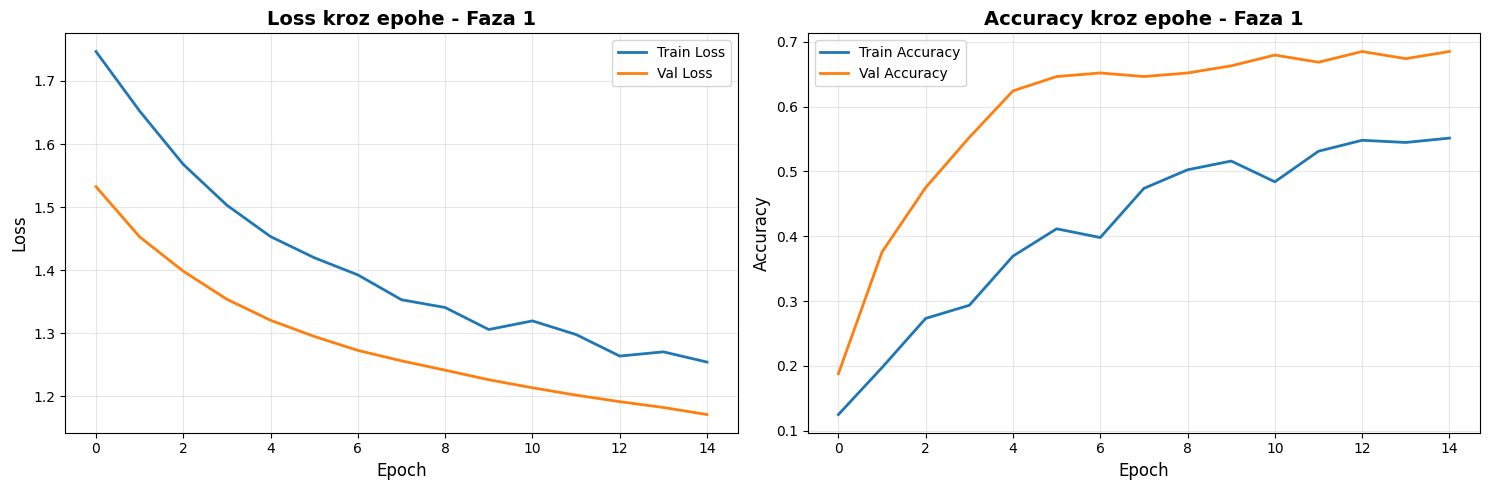

 Rezultati nakon Faze 1:
VAL  → Accuracy: 0.6851, Top-2 Acc: 0.8232, Loss: 1.1707
TEST → Accuracy: 0.6731, Top-2 Acc: 0.8365, Loss: 1.1764


In [9]:
# Vizualizacija rezultata Faze 1
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_phase1.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_phase1.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss kroz epohe - Faza 1', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_phase1.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history_phase1.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy kroz epohe - Faza 1', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluacija
val_loss, val_acc, val_top2 = model.evaluate(val_generator, verbose=0)
test_loss, test_acc, test_top2 = model.evaluate(test_generator, verbose=0)

print("="*50)
print(" Rezultati nakon Faze 1:")
print("="*50)
print(f"VAL  → Accuracy: {val_acc:.4f}, Top-2 Acc: {val_top2:.4f}, Loss: {val_loss:.4f}")
print(f"TEST → Accuracy: {test_acc:.4f}, Top-2 Acc: {test_top2:.4f}, Loss: {test_loss:.4f}")
print("="*50)

### 1.5 Faza 2 treniranja - Fine-tuning (postepeno odmrzavanje)

Sada prelazim u drugu fazu gde ću **odmrznuti poslednjih 30% slojeva** ResNet50V2 mreže. To znači da će se i ti slojevi trenirati i prilagođavati specifično za kožne lezije.

Treniraću još 25 epoha sa istim callback mehanizmima.

**Objašnjenje zašto odmrzavam samo poslednjih 30% slojeva**

- Niži slojevi (prvi deo mreže) prepoznaju generalne stvari (ivice, uglove, teksture) - njih ne treba dirati
- Learning rate smanjujem sa 1e-4 na **1e-5** (10x manji) jer ne želim da drastično menjam već naučene ImageNet težine. Treba pažljivo i polako "fine-tunovati".
- Viši slojevi (zadnji deo) prepoznaju specifičnije obrasce - njih treba prilagoditi našem problemu

In [ ]:
# Odmrznavanj poslednjih 30% slojeva
base_model.trainable = True

# Zamrzavanje prvih 70% slojeva
fine_tune_at = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f" Ukupno slojeva: {len(base_model.layers)}")
print(f" Zamrznuto prvih: {fine_tune_at}")
print(f" Trenira se: {len(base_model.layers) - fine_tune_at} slojeva")

# Manji learning rate za fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss,
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy')]
)

print("\n Započinjem treniranje - Faza 2 (fine-tuning)...")

# Treniranje Faza 2
history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

print(" Faza 2 završena!")

 Ukupno slojeva: 190
 Zamrznuto prvih: 133
 Trenira se: 57 slojeva

 Započinjem treniranje - Faza 2 (fine-tuning)...
Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4623 - loss: 1.3018 - top2_accuracy: 0.6649
Epoch 1: val_accuracy did not improve from 0.68508
38/38 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.4503 - loss: 1.3096 - top2_accuracy: 0.6678 - val_accuracy: 0.6796 - val_loss: 1.1704 - val_top2_accuracy: 0.8122 - learning_rate: 1.0000e-05
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4984 - loss: 1.2802 - top2_accuracy: 0.7065
Epoch 2: val_accuracy did not improve from 0.68508
38/38 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4789 - loss: 1.3026 - top2_accuracy: 0.6779 - val_accuracy: 0.6685 - val_loss: 1.1700 - val_top2_accuracy: 0.8343 - learning_rate: 1.0000e-05
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4972 - loss: 1.2776 - top2_accuracy: 0.6891
Epoch 3: val_accuracy did not improve from 0.68508
38/38 ━━━━━━━━━━━━

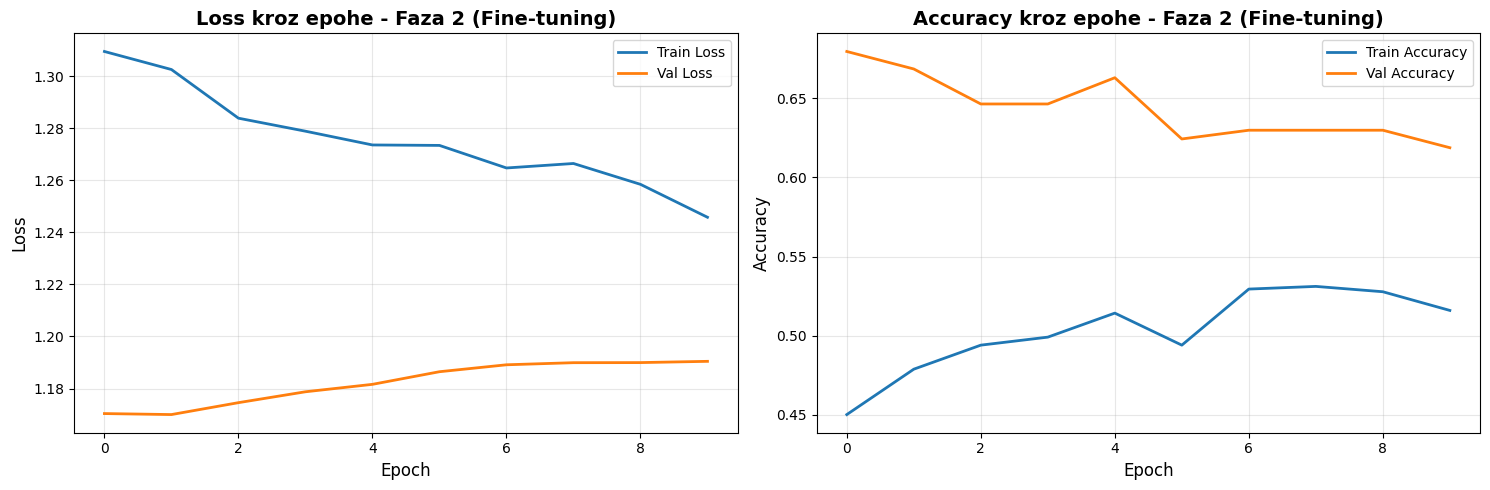

 FINALNI REZULTATI nakon Faze 2 (Fine-tuning):
VAL  → Accuracy: 0.6685 (66.85%)
       Top-2 Accuracy: 0.8343 (83.43%)
       Loss: 1.1700
TEST → Accuracy: 0.6731 (67.31%)
       Top-2 Accuracy: 0.7981 (79.81%)
       Loss: 1.1756
 Najbolji model sačuvan u: C:\Users\Acer\Desktop\best_resnet50v2_model.keras


In [12]:
# Vizualizacija rezultata Faze 2
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_phase2.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_phase2.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss kroz epohe - Faza 2 (Fine-tuning)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_phase2.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history_phase2.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy kroz epohe - Faza 2 (Fine-tuning)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Finalna evaluacija
val_loss, val_acc, val_top2 = model.evaluate(val_generator, verbose=0)
test_loss, test_acc, test_top2 = model.evaluate(test_generator, verbose=0)


print(" FINALNI REZULTATI nakon Faze 2 (Fine-tuning):")
print(f"VAL  → Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"       Top-2 Accuracy: {val_top2:.4f} ({val_top2*100:.2f}%)")
print(f"       Loss: {val_loss:.4f}")
print(f"TEST → Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"       Top-2 Accuracy: {test_top2:.4f} ({test_top2*100:.2f}%)")
print(f"       Loss: {test_loss:.4f}")
print(f" Najbolji model sačuvan u: {checkpoint_path}")

### 1.6 Evaluacija na test skupu - Confusion Matrix i metrike po klasama

Sada kad je model istreniran, vreme je da ga evaluiram na **test skupu** koji model nikad nije video tokom treniranja.

- **Normalized Confusion Matrix** - isti prikaz ali u procentima, lakše je za tumačenje
- **Confusion Matrix** - koje klase model najčešće meša između sebe
- **Classification Report** - precision, recall, F1-score za svaku klasu posebno

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


 CLASSIFICATION REPORT (TEST SET)
                            precision    recall  f1-score   support

         Actinic keratosis     0.6364    0.5833    0.6087        12
         Atopic Dermatitis     0.8571    1.0000    0.9231        12
          Benign keratosis     0.8182    0.7500    0.7826        12
            Dermatofibroma     0.6429    0.7500    0.6923        12
         Melanocytic nevus     0.7143    0.4167    0.5263        12
                  Melanoma     0.5000    0.3333    0.4000        12
   Squamous cell carcinoma     0.3333    0.5000    0.4000        12
Tinea Ringworm Candidiasis     0.8750    0.8750    0.8750         8
           Vascular lesion     0.8462    0.9167    0.8800        12

                  accuracy                         0.6731       104
                 macro avg     0.6915    0.6806    0.6764       104
              weighted avg     0.6844    0.6731    0.6688       104



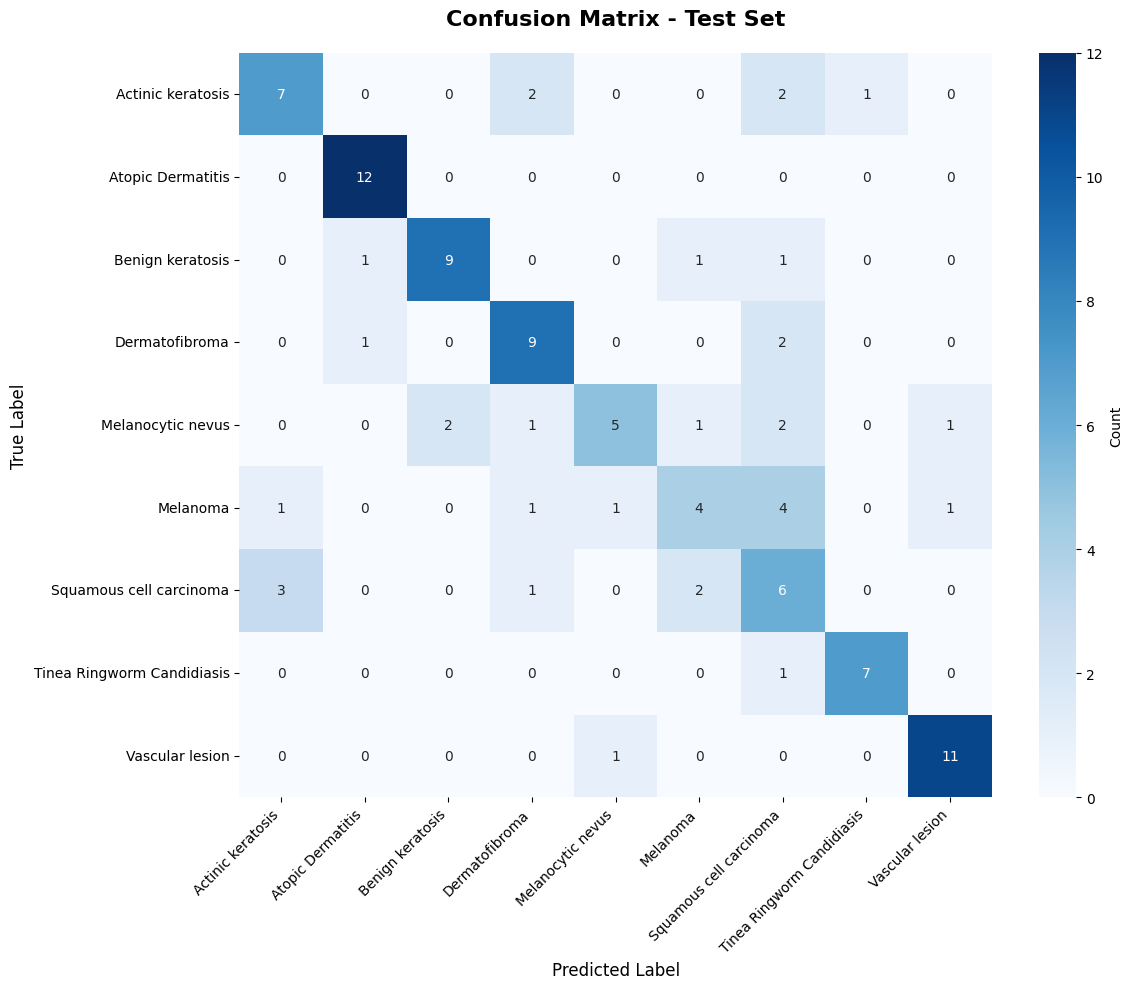

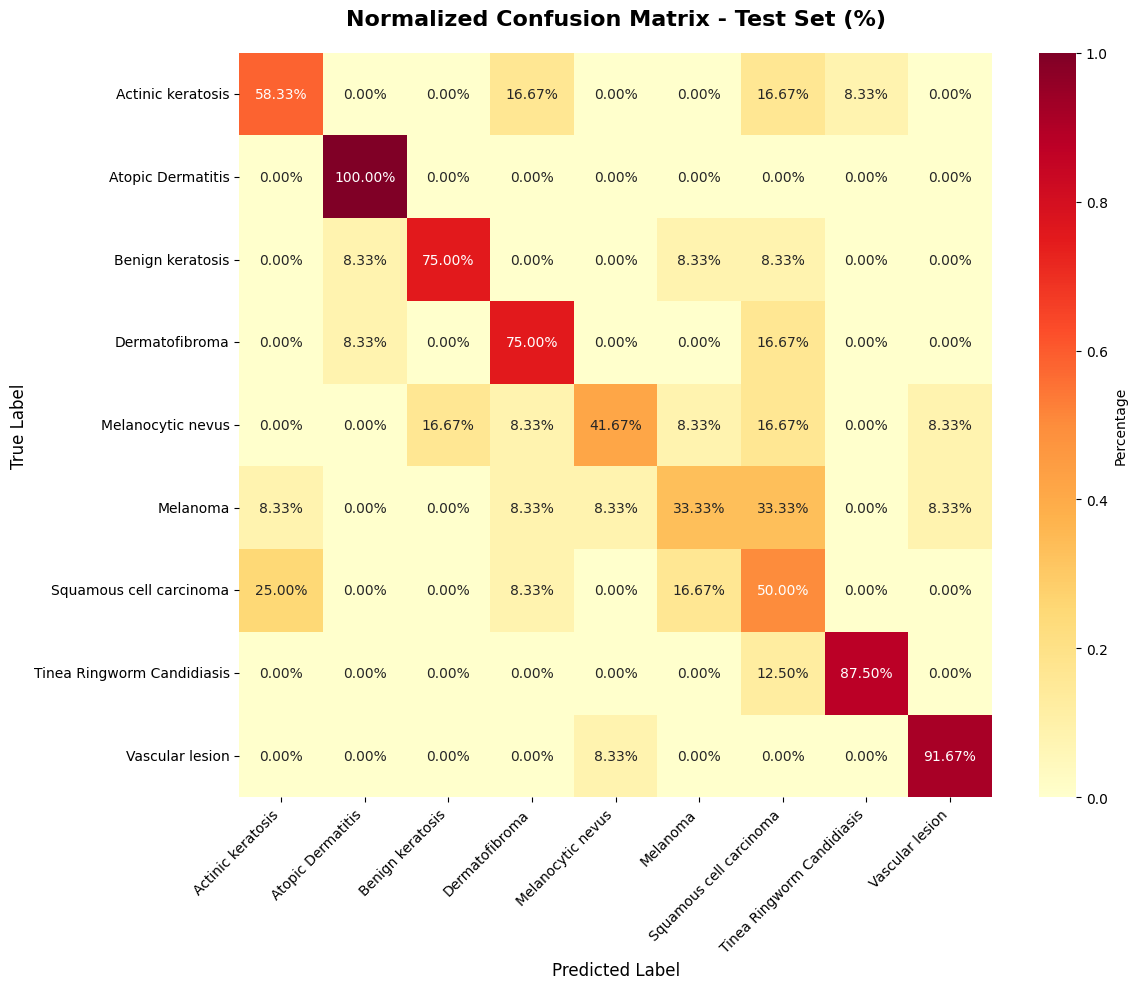

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predikcije na test skupu
test_generator.reset()
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\n")
print(" CLASSIFICATION REPORT (TEST SET)")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix 
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Test Set (%)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 1.7 Test Time Augmentation (TTA)

**TTA** znači da za jednu test sliku napravim više verzija (npr. originalna, pa rotirana, zumirana, blago pomerena). Svaku verziju prosledim kroz model, dobijem predikcije, pa izracunam srednju vrednost svih verovatnoća.

Primer: ako model za pet verzija iste slike daje različite verovatnoće po klasama, ja uzmem prosek tih verovatnoća i tek onda biram klasu sa najvecom vrednošću. Tako dobijem stabilniju i pouzdaniju odluku.

To radim kako bih poboljšala model i ono što ću dobiti tj. sam efekat TTA je:
- Smanjuje nasumične oscilacije u predikcijama
- Model "vidi" sliku iz više uglova
- U praksi često donosi 2-4% bolju tačnost

U ovom radu radim TTA sa **5 augmentacija** (1 originalna + 4 modifikovane). Što izaziva malo duže izvršavanje, ali samim tim jer je detaljnije rezultati mogu biti potencijalno bolji. 

In [ ]:

tta_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

def predict_with_tta(model, generator, num_augmentations=5):
    """Vrši TTA sa averaging više augmentovanih predikcija"""
    predictions = []
    
    print(f" Izvršavanje TTA sa {num_augmentations} augmentacija...")
    
    for i in range(num_augmentations):
        if i == 0:
            # Prva iteracija bez augmentacije
            gen = val_datagen.flow_from_directory(
                TEST_DIR,
                target_size=IMG_SIZE,
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                shuffle=False
            )
        else:
            # Ostale iteracije sa augmentacijom
            gen = tta_datagen.flow_from_directory(
                TEST_DIR,
                target_size=IMG_SIZE,
                batch_size=BATCH_SIZE,
                class_mode='categorical',
                shuffle=False
            )
        
        preds = model.predict(gen, verbose=0)
        predictions.append(preds)
        print(f"   Augmentacija {i+1}/{num_augmentations} završena")
    
    # Izračunavanje prosečnih predikcija
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions

# TTA predikcije
y_pred_tta = predict_with_tta(model, test_generator, num_augmentations=5)
y_pred_tta_classes = np.argmax(y_pred_tta, axis=1)

# TTA accuracy
tta_accuracy = np.mean(y_true == y_pred_tta_classes)
tta_top2_accuracy = np.mean([y_true[i] in np.argsort(y_pred_tta[i])[-2:] for i in range(len(y_true))])

print(" REZULTATI SA TEST TIME AUGMENTATION (TTA):")
print(f"TEST Accuracy (bez TTA): {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"TEST Accuracy (sa TTA):  {tta_accuracy:.4f} ({tta_accuracy*100:.2f}%)")
print(f"Poboljšanje: +{(tta_accuracy - test_acc)*100:.2f}%")
print(f"TEST Top-2 Acc (bez TTA): {test_top2:.4f} ({test_top2*100:.2f}%)")
print(f"TEST Top-2 Acc (sa TTA):  {tta_top2_accuracy:.4f} ({tta_top2_accuracy*100:.2f}%)")

 Izvršavanje TTA sa 5 augmentacija...
Found 104 images belonging to 9 classes.


c:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   Augmentacija 1/5 završena
Found 104 images belonging to 9 classes.
   Augmentacija 2/5 završena
Found 104 images belonging to 9 classes.
   Augmentacija 3/5 završena
Found 104 images belonging to 9 classes.
   Augmentacija 4/5 završena
Found 104 images belonging to 9 classes.
   Augmentacija 5/5 završena

 REZULTATI SA TEST TIME AUGMENTATION (TTA):
TEST Accuracy (bez TTA): 0.6731 (67.31%)
TEST Accuracy (sa TTA):  0.7019 (70.19%)
Poboljšanje: +2.88%
------------------------------------------------------------
TEST Top-2 Acc (bez TTA): 0.7981 (79.81%)
TEST Top-2 Acc (sa TTA):  0.8558 (85.58%)


### 1.8 Vizualizacija predikcija 

Prikazaću 12 slika sa pravom labelom, predviđenom labelom i confidence-om. 

**Zelena** boja = tačna predikcija, **Crvena** = netačna.

Korisno je pogledati nekoliko primera test slika kako bismo videli:

- Da li model pravilno klasifikuje očigledne slučajeve?
- Koliko je siguran u svoje predikcije? (confidence score)
- Koje slike su mu problematične?(netačne predikcije)

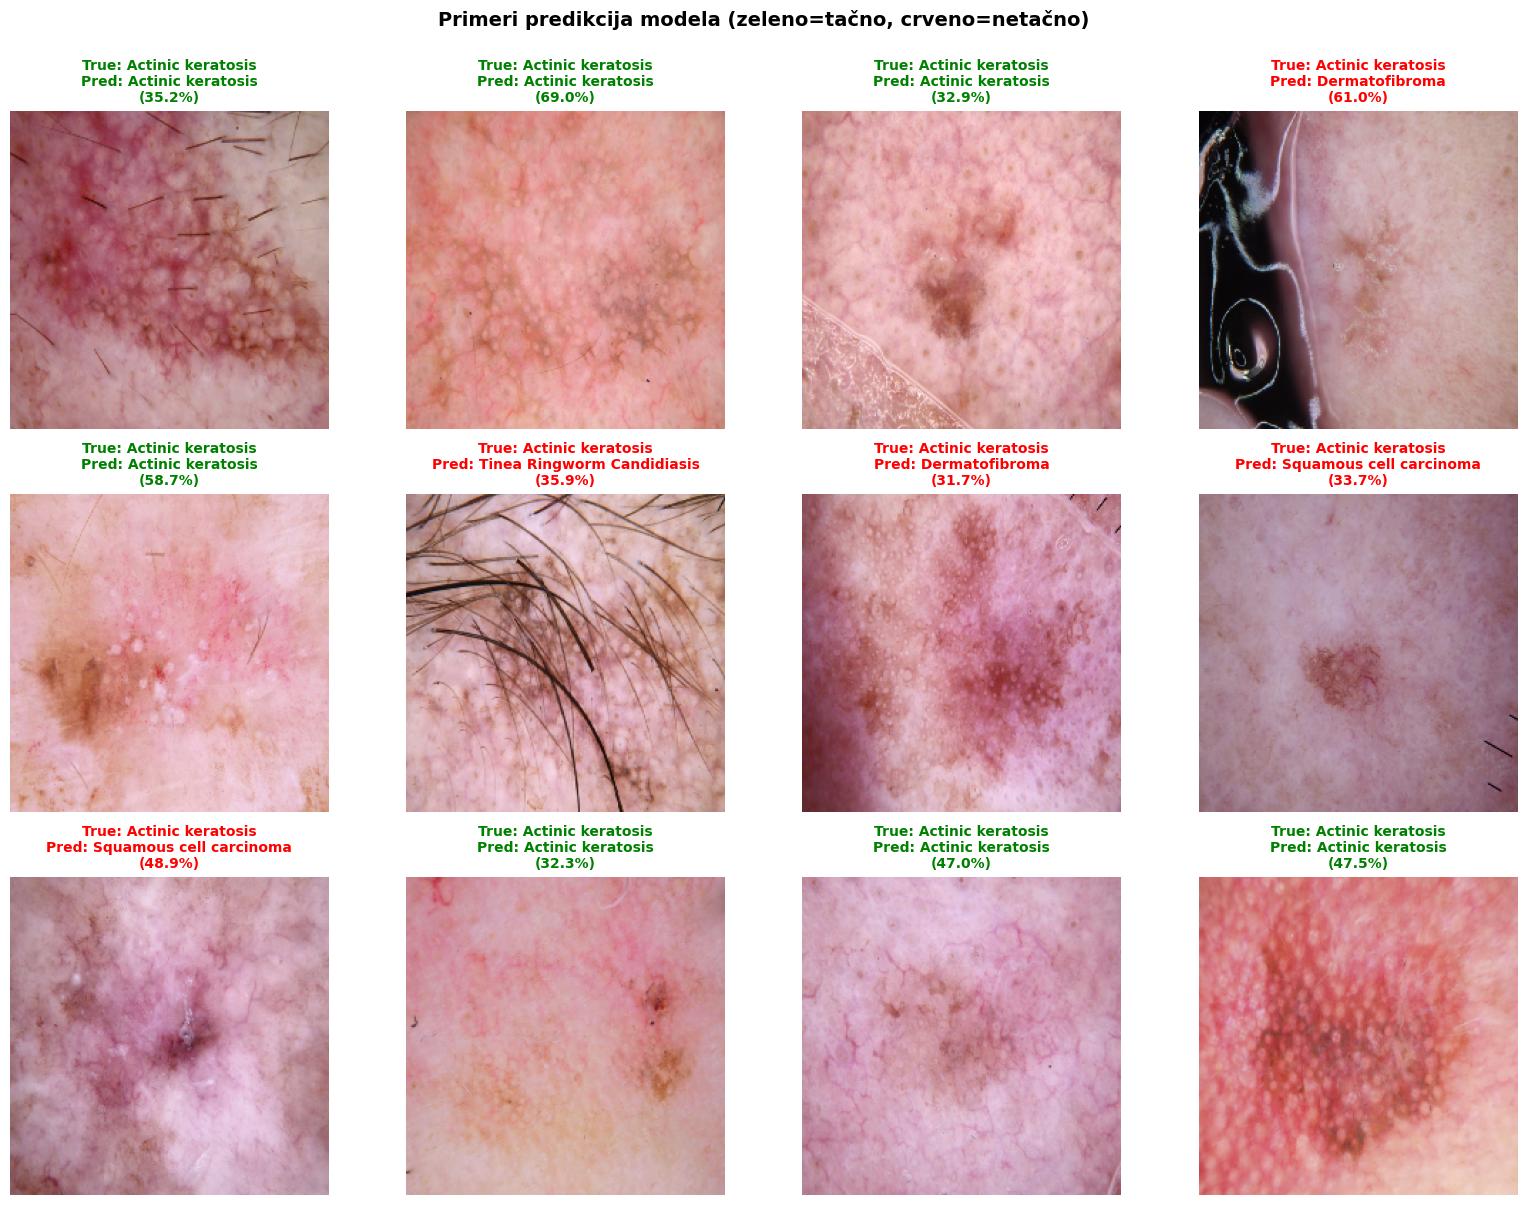

In [ ]:
import os
from tensorflow.keras.preprocessing import image

test_generator.reset()
x_test_batch, y_test_batch = next(test_generator)
y_pred_batch = model.predict(x_test_batch, verbose=0)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i in range(12):
    if i < len(x_test_batch):
        # Denormalizovanje slike za prikaz (ResNet preprocessing koristi [-1, 1])
        img = x_test_batch[i]
        img = (img + 1) / 2  # Vrati u [0, 1]
        img = np.clip(img, 0, 1)
        
        true_label = class_names[np.argmax(y_test_batch[i])]
        pred_label = class_names[np.argmax(y_pred_batch[i])]
        confidence = np.max(y_pred_batch[i]) * 100
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", 
                         fontsize=10, color=color, fontweight='bold')

plt.suptitle('Primeri predikcija modela (zeleno=tačno, crveno=netačno)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 2. Zaključak

Evo konkretnih brojeva iz analize koje sam postigla na test skupu koristeći TTA:
         
**Test Accuracy**  67.31% ->  **70.19%**  
**Top-2 Accuracy**  79.81% -> **85.58%**  
**Validation Accuracy**  66.85% ->   -

**Poboljšanje od TTA:** +2.88 procentnih poena

**Top-2 Accuracy od 85.58%** znači da u 85.58% slučajeva tačna dijagnoza je među **dve najverovatnije** predikcije modela. U medicinskoj praksi ovo je jako korisno - lekar dobija top-2 diferencijalne dijagnoze koje treba da razmotri.

**Odlična generalizacija**

Validation accuracy (66.85%) i test accuracy (67.31%) su skoro identični. To znači da model NIJE overfit-ovao - naučio je generalne obrasce koji važe i na neviđenim slikama. Razlika od 0.46% je zanemariva i pokazuje da je trening bio stabilan.

**Problem sa retkim klasama**

Confusion matrix je pokazao da model ima problema sa klasama koje imaju najmanje uzoraka:
- **Melanoma**: 33% recall (propušta 2/3 slučajeva)
- **Melanocytic nevus**: 42% recall (propušta više od polovine)
- **Squamous cell carcinoma**: 50% recall

Ovo je očekivano jer:
1. Ove klase imaju veoma mali broj treniranih slika
2. Vizuelno su slične drugim lezijama (teško ih je razlikovati čak i za ljude)
3. Focal Loss i class weights pomažu, ali ne mogu u potpunosti kompenzovati nedostatak podataka

**Rešenje:** Potrebno je prikupiti više slika za ove klase ili koristiti tehnike kao što su oversampling/SMOTE.

Model postiže **solidne rezultate** za medicinski dataset sa svega nekoliko stotina slika po klasi. Tačnost od 70% i Top-2 accuracy od 85.58% čine ga korisnim kao **sistem podrške odlučivanju** u kliničkoj praksi, ali samo kao pomoćni deo tj. kao asistent,a ne kao jedini vid odlučivanja. 

**Šta bi sledeće trebalo uraditi za poboljšanje:**
1. **Proširiti dataset** - prikupiti 2-3x više slika, posebno za ređe klase
2. **Kvalitet podataka** - standardizovati kvalitet slika (rezolucija, osvetljenje, ugao snimanja)
3. **Ensemble modeli** - kombinovati ResNet50V2 sa drugim arhitekturama (EfficientNet, Vision Transformer)
4. **Domain-specific augmentacije** - konsultovati dermatologe o tome koje transformacije su medicinski validne
5. **Uncertainty estimation** - dodati mehanizam koji govori "nisam siguran" za teške slučajeve

U odnosu na prošli model RestNet50 ovaj je prikazao veoma slične rezultate. Tako da bi neki uopšten zaključak bio, da iako sam primenila neke da kažem "strože tehnike", na drugačiji način izvela treniranje, mislim da je veći problem sam dataset i to što su slike u par klasa dosta slične tj. takva im je priroda. Kao što sam gore već napisala u nekom budućem periodu bi možda kombinacija modela bila efikasnija, i samo proširivanje i menjanje dataseta...
